In [3]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt  # for plotting general data
import seaborn as sns  # for statistical data visualization

# data wrangling
import pandas as pd
import numpy as np

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# data exploration
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# learning
from sklearn.linear_model import LogisticRegression

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)
print("seaborn                               Your version: %s" % sns.__version__)

pandas        Tested version: 2.0.3   Your version: 2.2.3
numpy         Tested version: 1.21.5  Your version: 2.2.4
matplotlib    Tested version: 3.5.3   Your version: 3.10.1
scikit-learn  Tested version: 1.2.2   Your version: 1.6.1
seaborn                               Your version: 0.13.2


# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [4]:
# description
description = pd.read_csv('./data/WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('./data/training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [5]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['immunosuppression']

{'Category': 'APACHE comorbidity',
 'Unit of Measure': nan,
 'Data Type': 'binary',
 'Description': 'Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).',
 'Example': '1'}

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [6]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [7]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
df_amountmissing = X_train.isna().sum() > max_missing * len(X_train)
df_amountmissing = df_amountmissing[df_amountmissing].index
X_train = X_train.drop(df_amountmissing, axis=1)
X_val = X_val.drop(df_amountmissing, axis=1)
X_test = X_test.drop(df_amountmissing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])

# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer', SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B156EEE830>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B156E67D00>)])

Time: 1.17s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [8]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 10.09s


c:\Users\jolme\Documents\School\2IX30 - Responsible Data Science\2IX30_2025\.env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


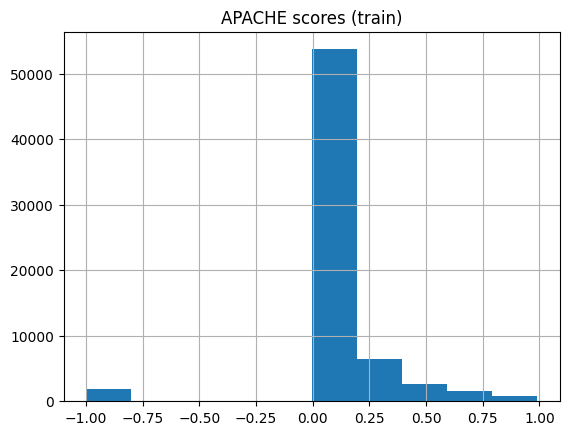

In [9]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

# Data Exploration

## General data shape

In [10]:
# df holds all the data in training_v2.csv
# print dataframe shape
print(f"rows: {df.shape[0]}, columns: {df.shape[1]}, total data points: {df.size}")

rows: 91713, columns: 186, total data points: 17058618


In [11]:
# dataframe stats
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing Value analysis

In [12]:
# This cell creates a report on the missing values in the data set

# -- determine percentage of missing values per column -- #

df_amountmissing = df.isna().sum().sort_values(ascending=False) # percentage of missing values in each column, sorted from high to lowest
df_amountmissing.drop(labels='hospital_death', inplace=True)    # remove target variable (hospital_death) from the missing value rapport (its fully present)

# remove ID-cols (only if they indeed don't have missing values)
for colname in df_amountmissing.index:
    if df_amountmissing[colname] == 0 and '_id' in colname:
        df_amountmissing.drop(colname, inplace=True)


# -- pretty print each column missing values with percentage sign -- #

print("Percentage of missing values per column:")

# align column names and percentages by determining the correct padding of spaces
max_col_len = max([len(cname) for cname in df_amountmissing.index])

# print column names, percentages missing, and totals ratio (missing / total)
for cname, nr_missing in df_amountmissing.items():
    print(f"{cname}{' ' * (max_col_len - len(cname))}: {nr_missing/df.shape[0]:.2%} ({df[cname].isna().sum()} / {df.shape[0]})")


# -- determine number of features with more than 0, 25%, 33%, 50%, 66%, 75% missing values -- #

# no missing values
print(f"Columns without missing values:")
df_nomissing = df_amountmissing[df_amountmissing == 0]
for colname in df_nomissing.index:
    print(f"\t{colname}")

# x% missing values
for threshold_ratio in [0.25, 1/3, 0.5, 2/3, 0.75]:
    df_percentage = df_amountmissing[df_amountmissing > (threshold_ratio * df.shape[0])]
    print(f"Features with > {threshold_ratio:.0%} missing values ({len(df_percentage)}):")
    for i, colname in enumerate(df_percentage.index):
        print(f"\t{i+1}. {colname}")

Percentage of missing values per column:
h1_bilirubin_min             : 92.27% (84619 / 91713)
h1_bilirubin_max             : 92.27% (84619 / 91713)
h1_lactate_min               : 91.99% (84369 / 91713)
h1_lactate_max               : 91.99% (84369 / 91713)
h1_albumin_max               : 91.40% (83824 / 91713)
h1_albumin_min               : 91.40% (83824 / 91713)
h1_pao2fio2ratio_min         : 87.44% (80195 / 91713)
h1_pao2fio2ratio_max         : 87.44% (80195 / 91713)
h1_arterial_ph_max           : 83.33% (76424 / 91713)
h1_arterial_ph_min           : 83.33% (76424 / 91713)
h1_hco3_max                  : 82.97% (76094 / 91713)
h1_hco3_min                  : 82.97% (76094 / 91713)
h1_arterial_pco2_max         : 82.82% (75959 / 91713)
h1_arterial_pco2_min         : 82.82% (75959 / 91713)
h1_wbc_max                   : 82.82% (75953 / 91713)
h1_wbc_min                   : 82.82% (75953 / 91713)
h1_arterial_po2_min          : 82.81% (75945 / 91713)
h1_arterial_po2_max          : 82.81% (75

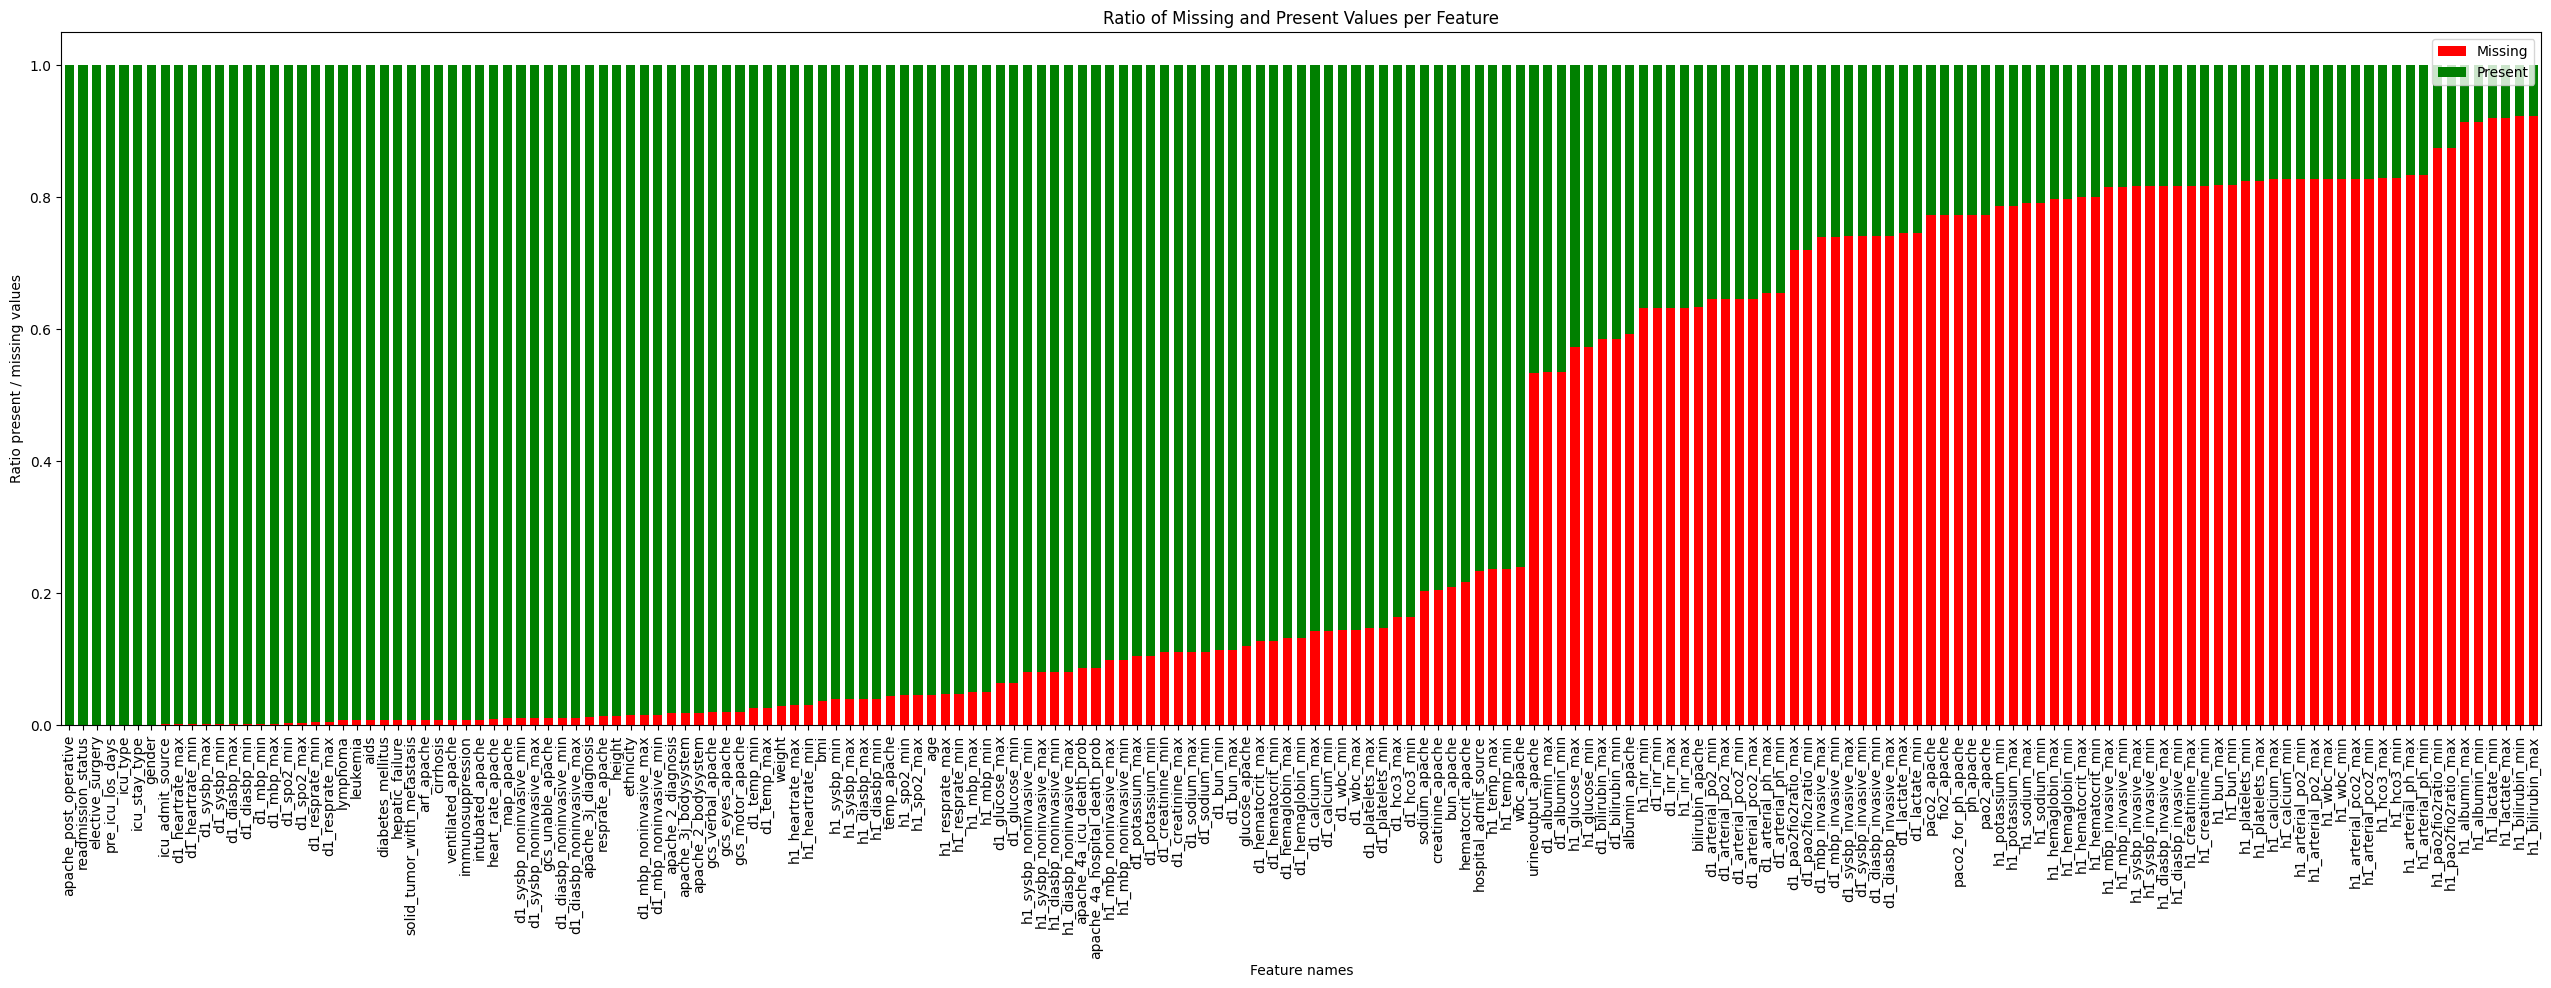

In [13]:
# this cell visualizes the above missing values report using a bar chart

# -- compute ratios of missing and present values -- #

# Calculate the ratio of missing and present values
missing_ratio = df_amountmissing.sort_values(ascending=True) / df.shape[0]
present_ratio = 1 - missing_ratio

ratio_df = pd.DataFrame( # combine dataframes for plotting + add column names
    {
        'Missing': missing_ratio, 
        'Present': present_ratio
    }
) 

# -- plot ratio's -- #

# Plot the stacked bar (e.g. ratio) chart, with orange for the missing values and green for the present values, with present on bottom and missing on top
# swap so that the missing values are stacked on top of the present values

# plot visual settings
plot_ratio = 32 / 9 # aspect ratio of the plot
plot_scale = 9     # scale of the plot, increase to make the plot larger (affects png resolution and label size) (default-size = plot_ration denominator) 

# actual plot
ratio_df.plot(kind='bar', stacked=True, figsize=(plot_scale*plot_ratio, plot_scale), color=['red', 'green'], width=.6666)

# labels
plt.xlabel('Feature names')
plt.ylabel('Ratio present / missing values')

# plot context
plt.title('Ratio of Missing and Present Values per Feature')
plt.legend(loc='upper right')

plt.show()

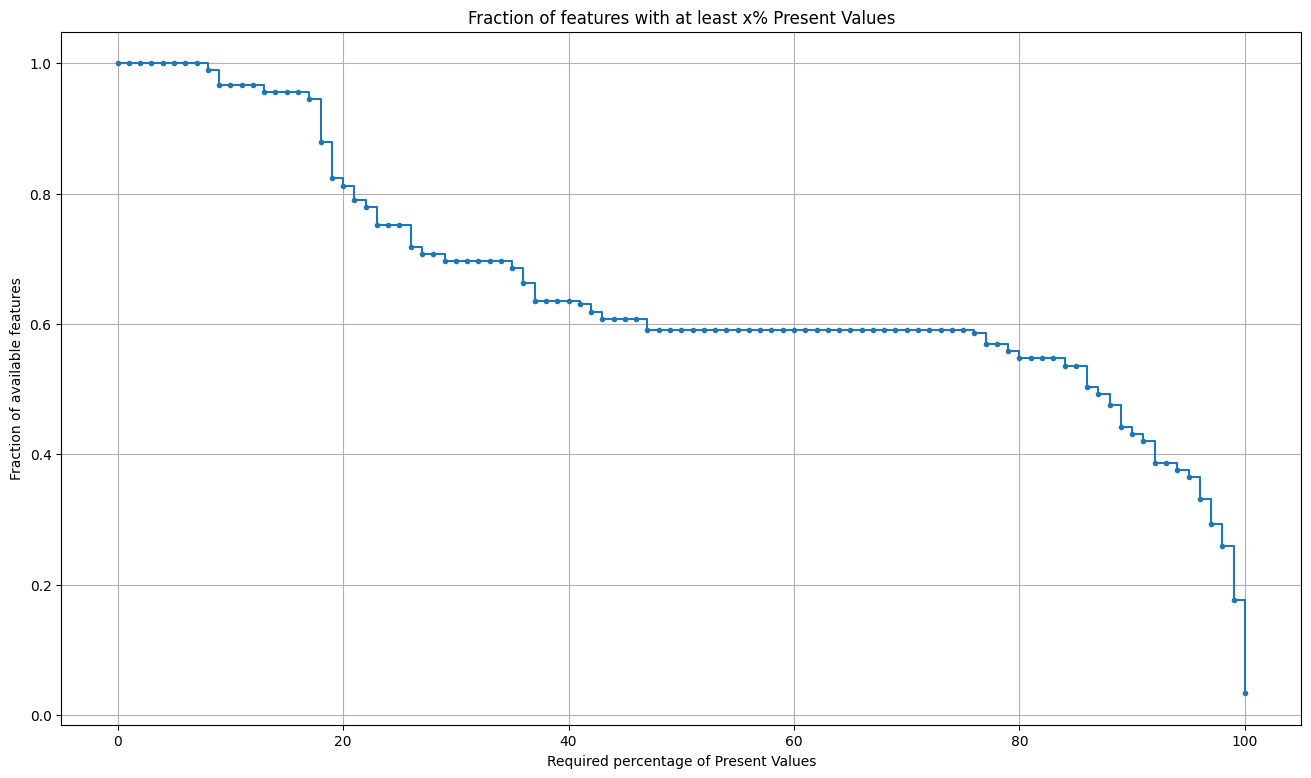

In [14]:
# this cell visualizes how many features have at least x% of their values present,
# which is useful for threshold selection for the confidence interval.

# Calculate the percentage of present values for each feature
present_percentage = present_ratio * 100

# Create a list to store the number of features for each percentage threshold
thresholds = np.arange(0, 101, 1) # from 0% to 100%
valid_features = [(present_percentage >= threshold).sum() / present_percentage.shape[0] for threshold in thresholds]

# Plot the number of features as a function of the percentage threshold
plt.figure(figsize=(16, 9))

# discreet line plot
plt.step(thresholds, valid_features, where='post', linestyle='-', marker='.')

plt.xlabel('Required percentage of Present Values')
plt.ylabel('Fraction of available features')
plt.title('Fraction of features with at least x% Present Values')
plt.grid(True)
plt.show()

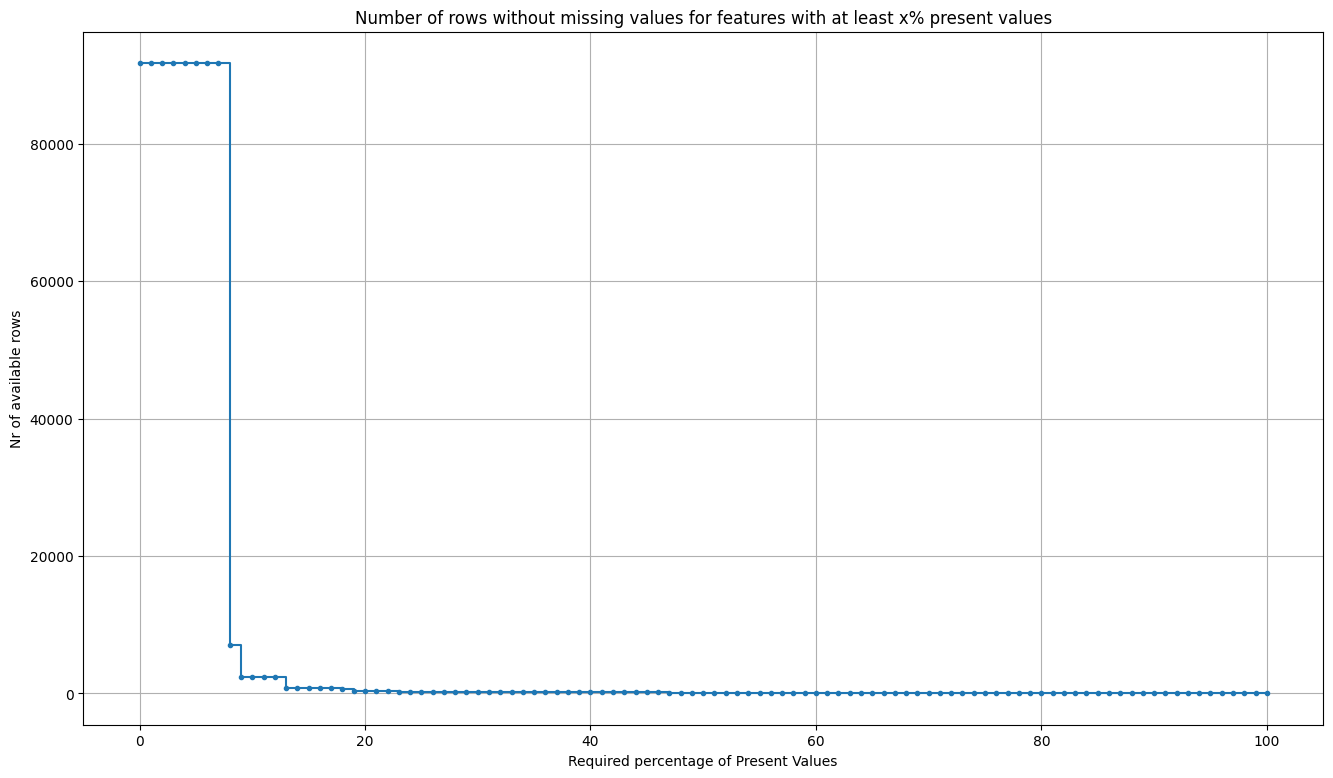

In [15]:
# Computes the size of the data set, if rows with missing values are removed for features with at least x% present values.
# Could be usefull to determine where to set the threshold for missing values. Conclusion: Its unfeasible to remove rows with missing values in highly eroded data sets.

# threshold = threshold
# present_percentage = present_percentage

nr_valid_rows = [0 for _ in range(len(thresholds))]
for threshold in thresholds:
        forbidden_columns = present_percentage[present_percentage < threshold].index
        nr_valid_rows[threshold] = len(df.dropna(subset=forbidden_columns))
        

# Plot the number of features as a function of the percentage threshold
plt.figure(figsize=(16, 9))

# discreet line plot
plt.step(thresholds, nr_valid_rows, where='post', linestyle='-', marker='.')

plt.xlabel('Required percentage of Present Values')
plt.ylabel('Nr of available rows')
plt.title('Number of rows without missing values for features with at least x% present values')
plt.grid(True)
plt.show()

## Feature Distribution Analysis


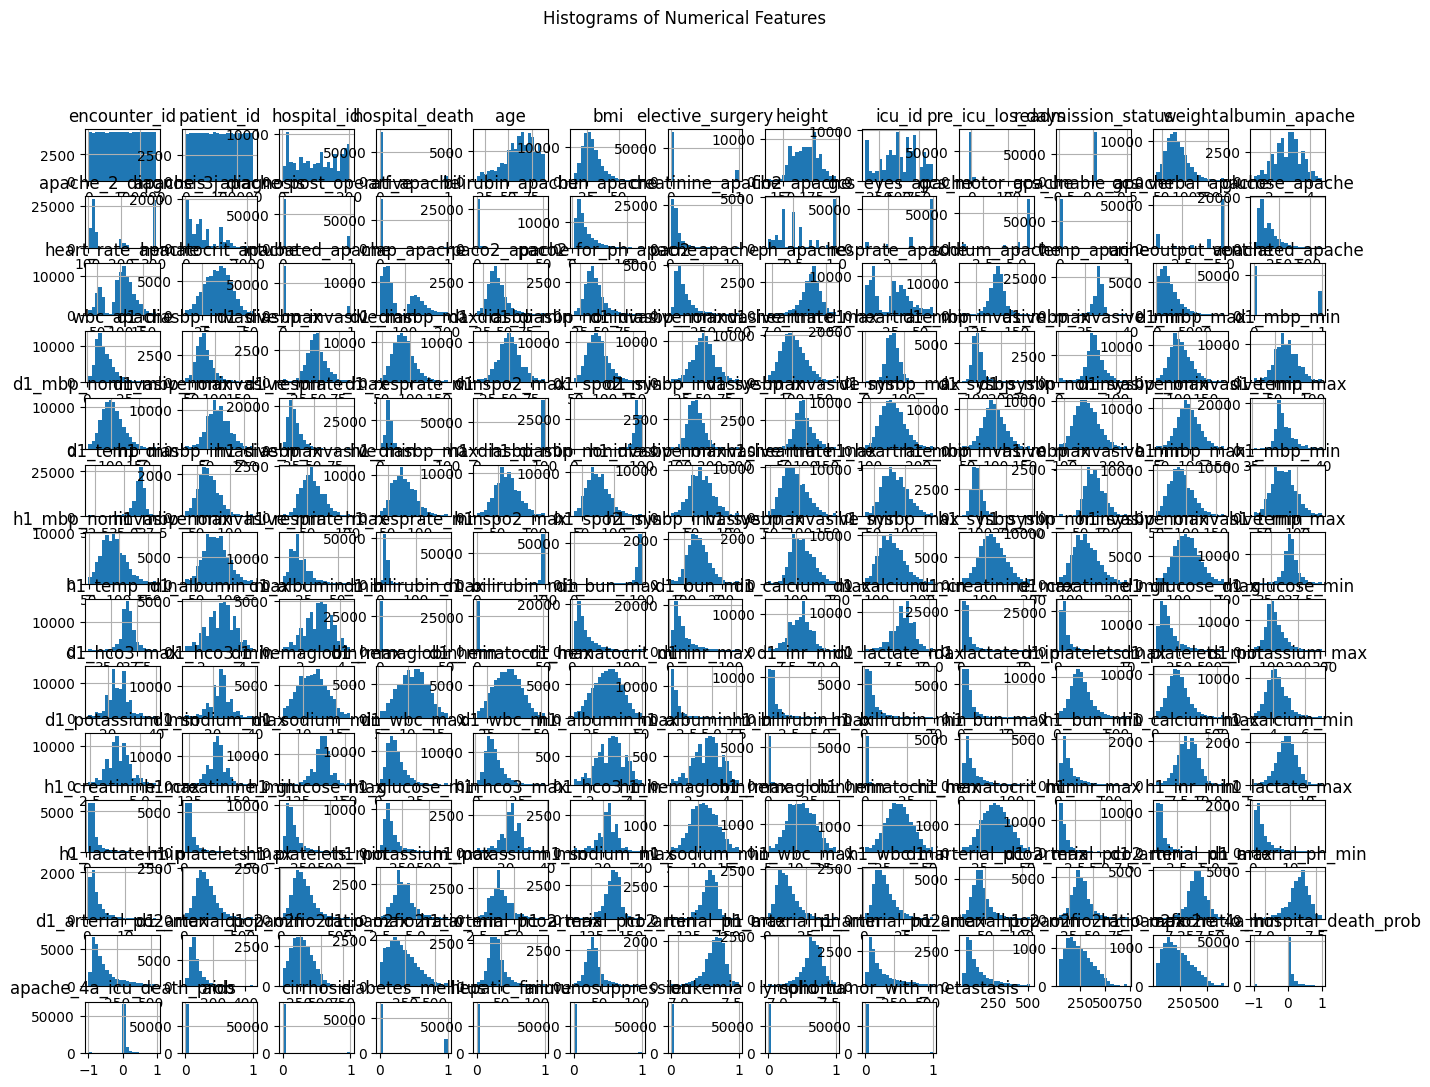

In [16]:
# Analyze the distribution of numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_features].hist(figsize=(16, 12), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()


In [17]:

# Analyze the distribution of categorical features

# Calculate the ratio of each category within each categorical feature
ratios: pd.DataFrame = df.select_dtypes(include=['object']).apply(lambda x: x.value_counts(normalize=True))

# -- sort the categories by ratio, group small categories -- #

RATIO_MIN = 0.05 # minimum ratio of a category to be included in the visualization
category_ratios: dict[str, pd.Series] = {}
for feature_category in ratios.columns:
    ratios: pd.Series = ratios[feature_category].copy().dropna().sort_values(ascending=True)

    # only keep the categories with a ratio > RATIO_MIN, sum and rename the rest to 'other'
    small_total = ratios[ratios < RATIO_MIN].sum()
    ratios = ratios[ratios >= RATIO_MIN]
    if small_total > 0: ratios["other"] = small_total

    category_ratios[feature_category] = ratios


KeyError: 'gender'

NameError: name 'cummmulative_height' is not defined

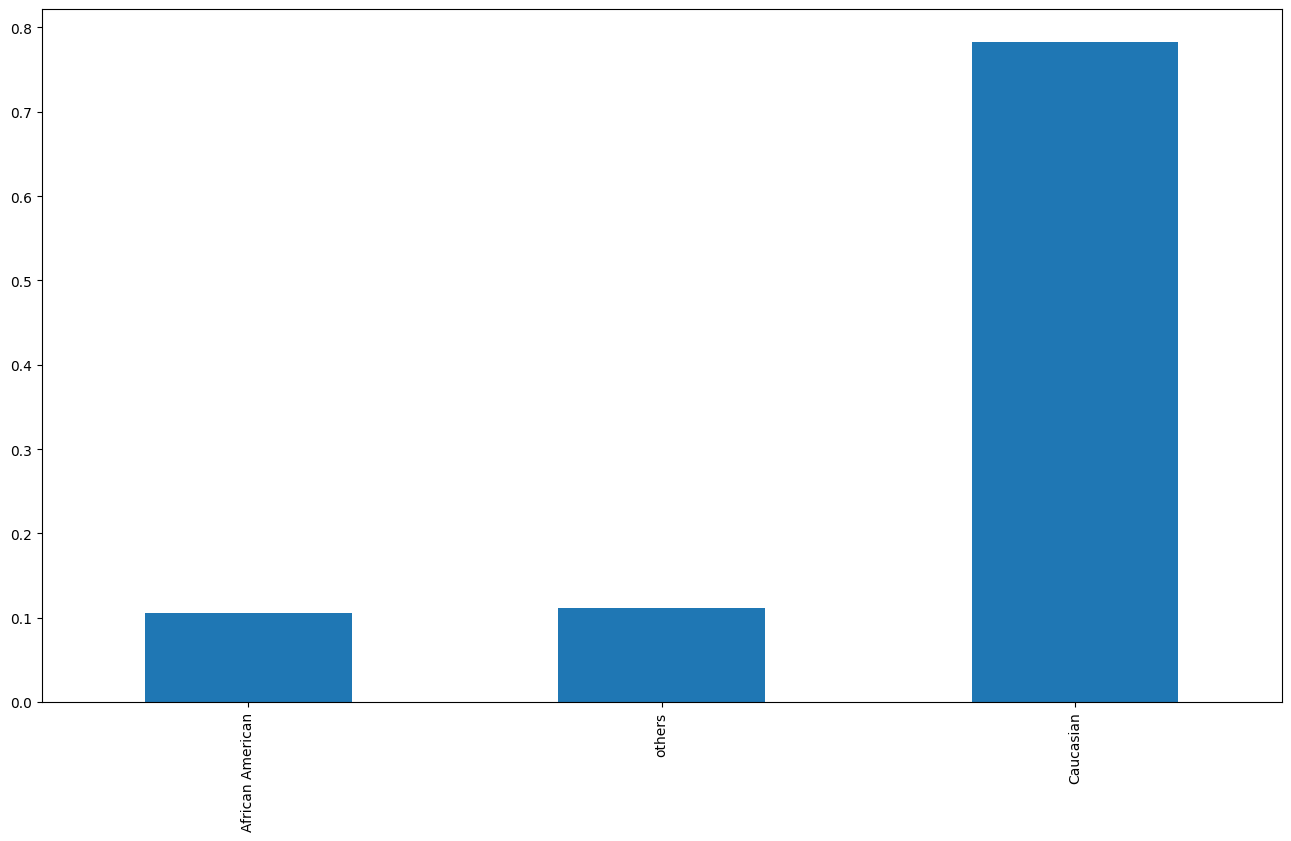

In [ ]:

# Plot the stacked bar chart for each categorical feature with labels
fig, ax = plt.subplots(figsize=(16, 9)) # create figure and axis

# plot each feature's categories as a stacked bar
for feature, ratios in category_ratios.items():
    cummulative_height = 0

    # plot segments of each feature.
    ratios.plot(kind='bar', stacked=True, ax=ax, bottom=cummulative_height, label=feature, width=0.5)
    cummmulative_height += ratios


plt.xlabel('Categorical Feature Names')
plt.ylabel('Ratio of Categories')
plt.title('Ratio of Categories per Categorical Feature')
plt.legend().remove()
plt.show()


## Feature Correlation analysis

In [ ]:
# Correlation Analysis

# Preprocess the dataframe to encode categorical features as one-hot encoded features
df_encoded = df.copy()

# oneHot encoder that creates dummy variables from each category
categorical_transformer = Pipeline(steps=[
        ("category_dummies", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))
    ])

# -- preprocessing pipeline for correlation analysis -- #

# pipeline : 
# 1. oneHot encoder to create dummy variables.
pipeline = ColumnTransformer(
    transformers=[
        ('is_category', categorical_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object (e.g. strings)
    ])

# fit the transformers to the data (determine required info for each transformation)
pipeline.fit(df_encoded)

# apply the pipeline to the data
df_encoded = pd.DataFrame(pipeline.transform(df_encoded), columns=pipeline.get_feature_names_out())

# Add the dummy variables to the original dataframe
df_encoded = pd.concat([df.drop(columns=df.select_dtypes(include=['object']).columns), df_encoded], axis=1)

print(df_encoded.columns)

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days',
       ...
       'is_category__apache_2_bodysystem_Gastrointestinal',
       'is_category__apache_2_bodysystem_Haematologic',
       'is_category__apache_2_bodysystem_Metabolic',
       'is_category__apache_2_bodysystem_Neurologic',
       'is_category__apache_2_bodysystem_Renal/Genitourinary',
       'is_category__apache_2_bodysystem_Respiratory',
       'is_category__apache_2_bodysystem_Trauma',
       'is_category__apache_2_bodysystem_Undefined Diagnoses',
       'is_category__apache_2_bodysystem_Undefined diagnoses',
       'is_category__apache_2_bodysystem_nan'],
      dtype='object', length=236)


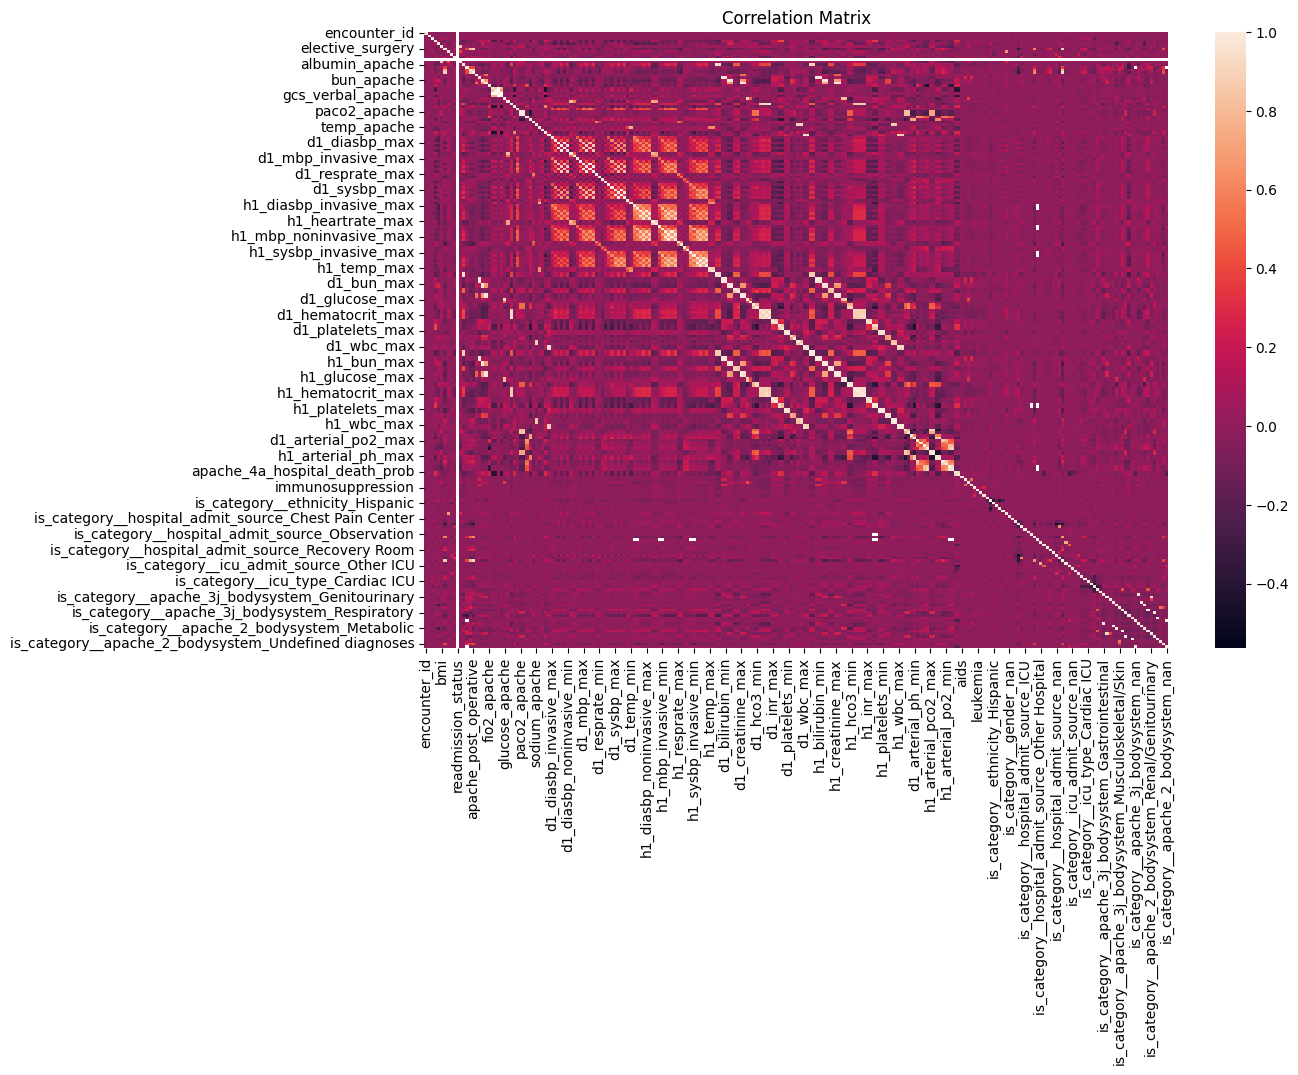

In [ ]:
# compute the correlation matrix
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix')
plt.show()


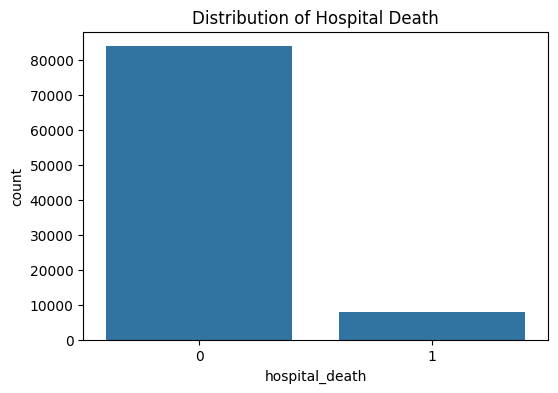

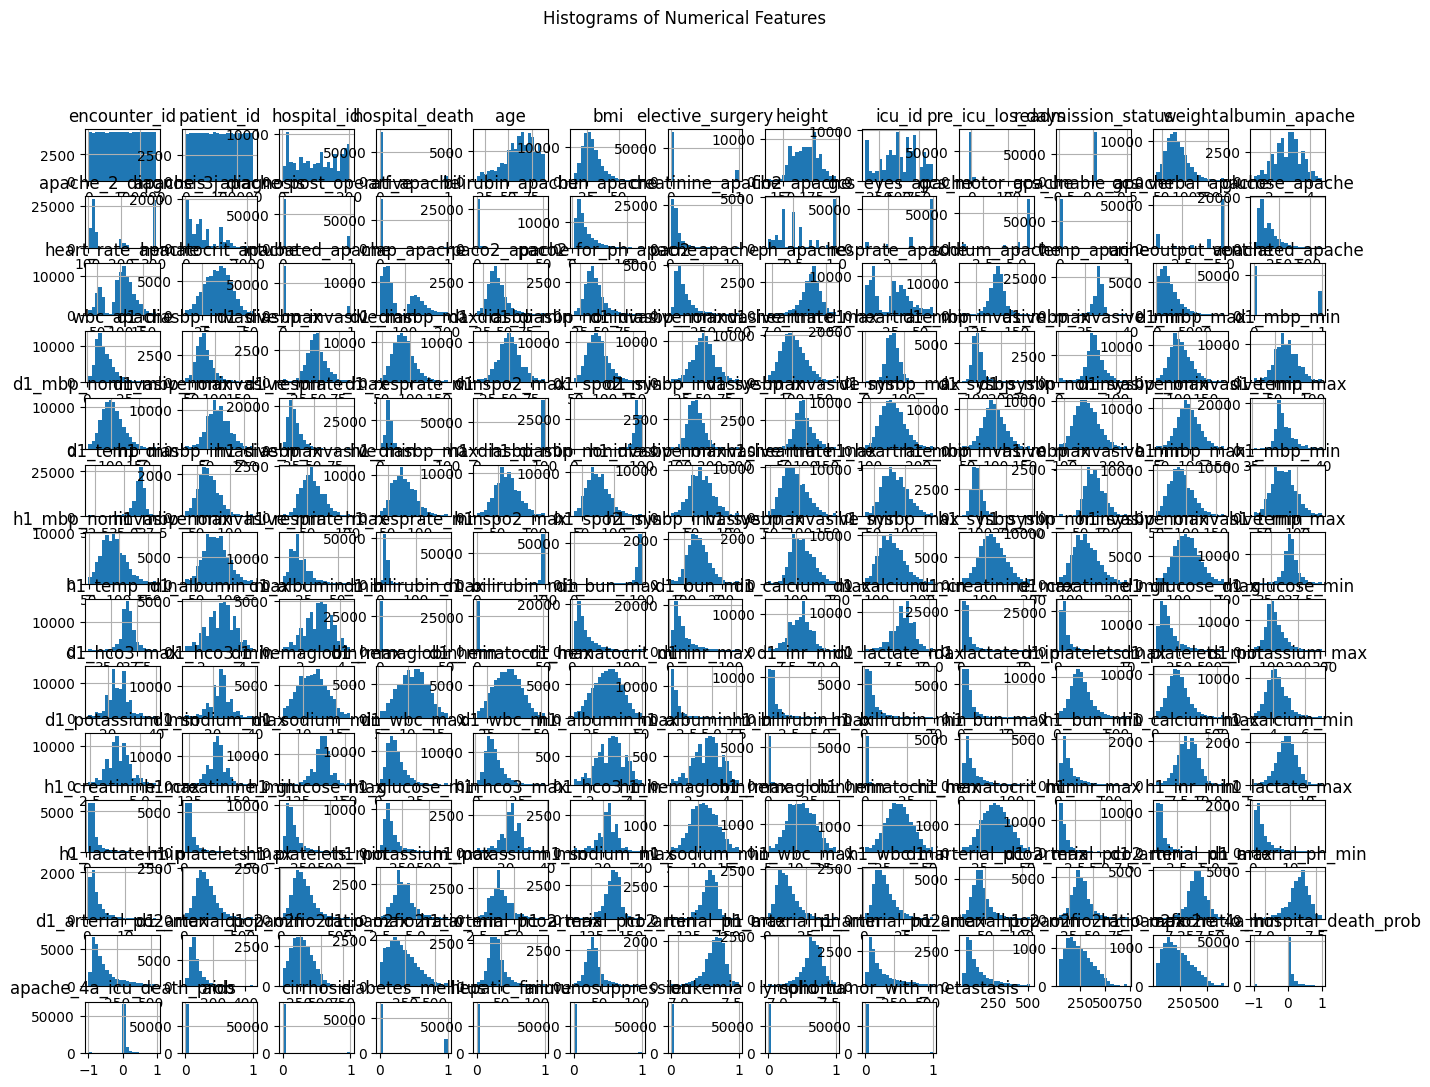

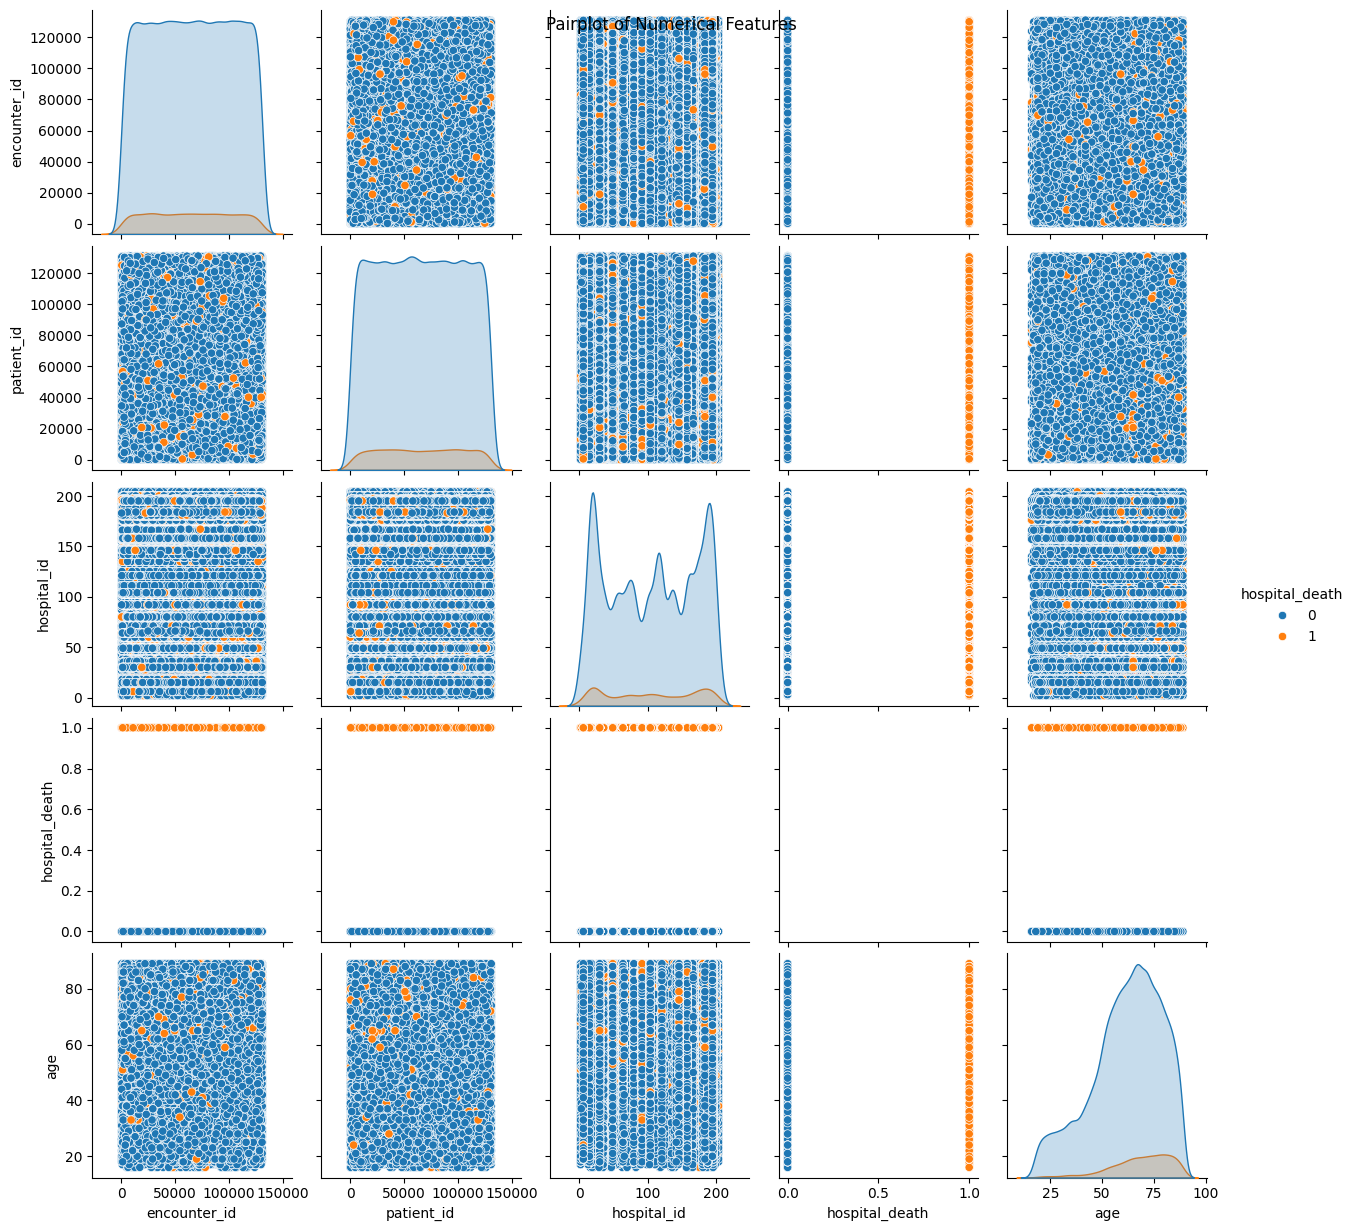

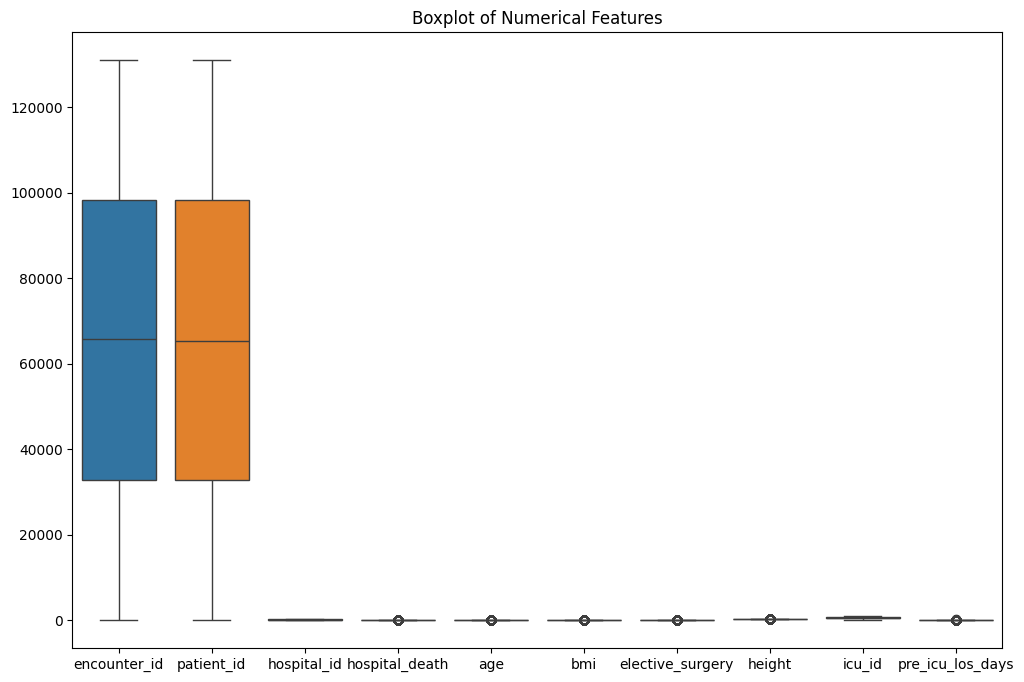

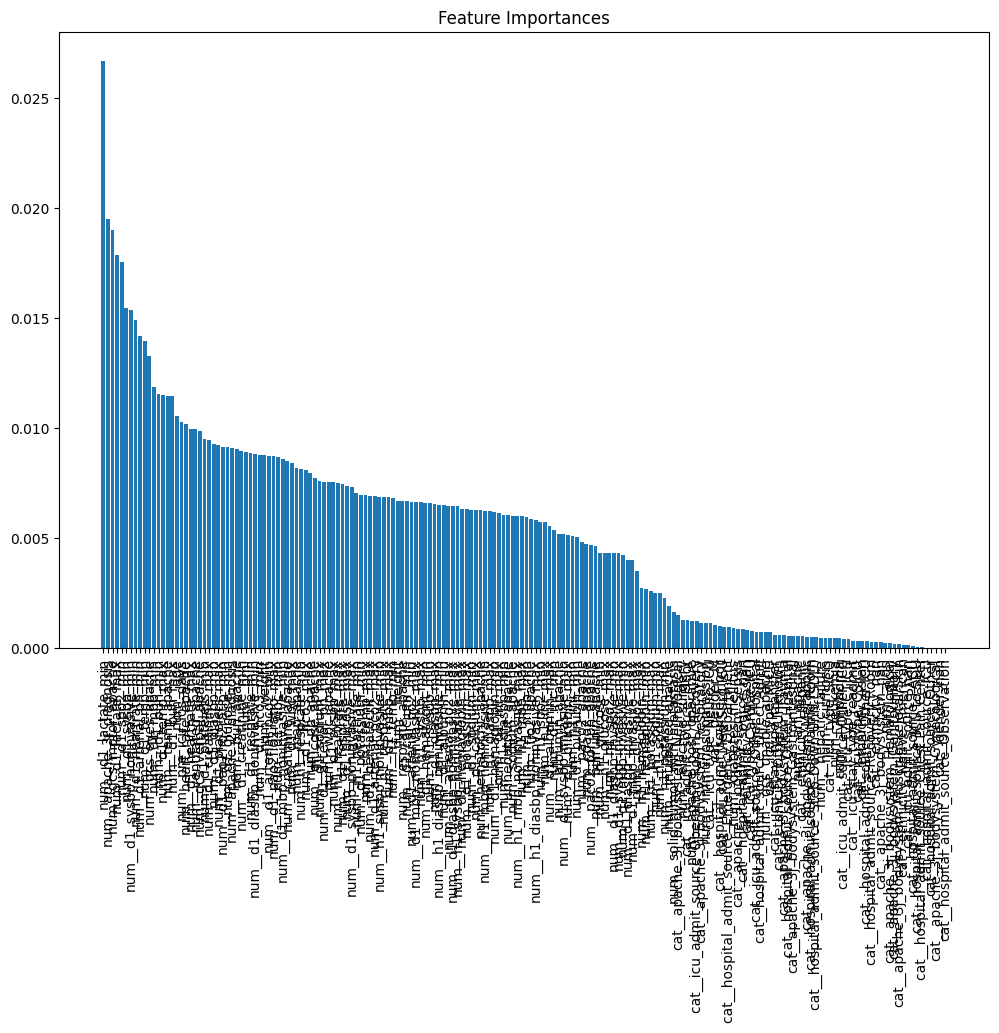

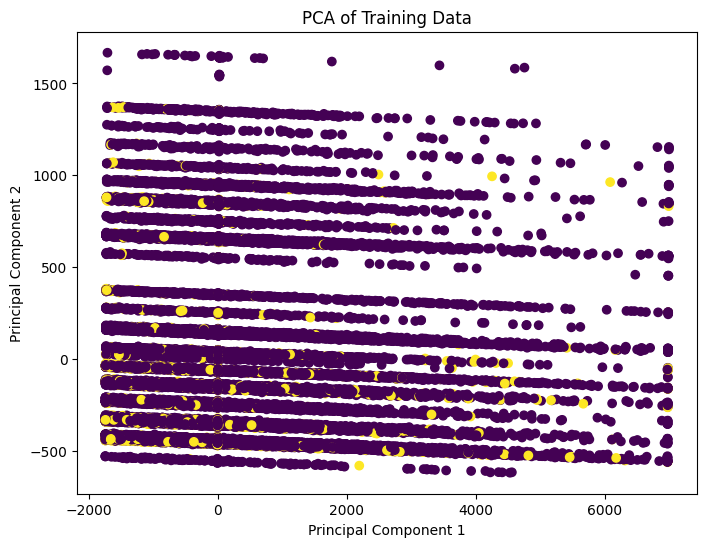

hospital_death
0    83798
1     7915
Name: count, dtype: int64


In [18]:

# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_death', data=df)
plt.title('Distribution of Hospital Death')
plt.show()

# Feature Distribution
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_features].hist(figsize=(16, 12), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Feature Relationships
sns.pairplot(df, hue='hospital_death', vars=numerical_features[:5])
plt.suptitle('Pairplot of Numerical Features')
plt.show()

# Outlier Detection
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_features[:10]])
plt.title('Boxplot of Numerical Features')
plt.show()

# Feature Importance

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

# PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Class Imbalance
class_counts = df['hospital_death'].value_counts()
print(class_counts)

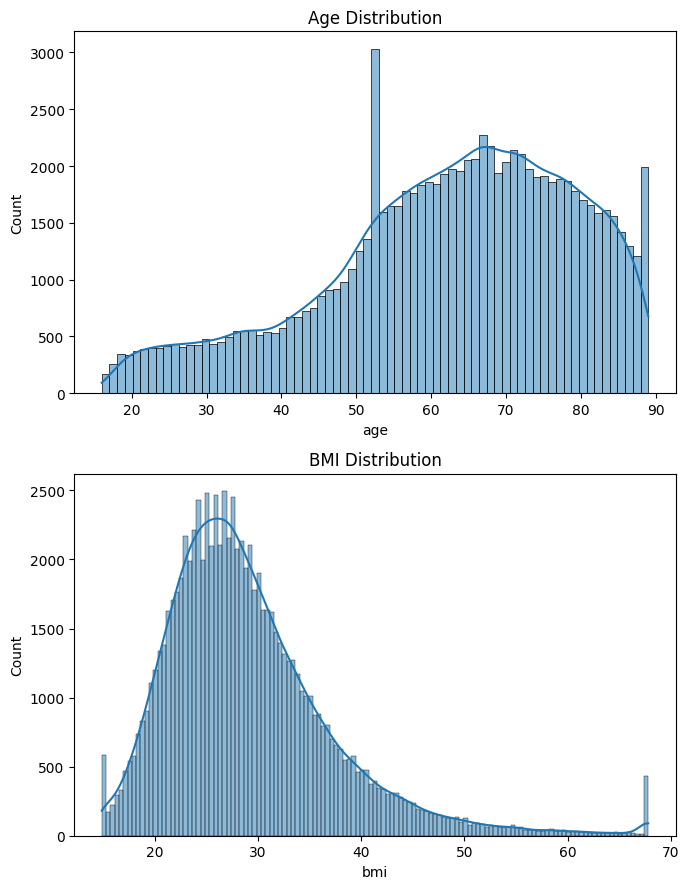

In [22]:
# Plot age distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Data distribution for some key features
fig, axs = plt.subplots(2, 1, figsize=(7, 9))

# Age distribution
sns.histplot(df['age'].dropna(), kde=True, ax=axs[0])
axs[0].set_title('Age Distribution')

# BMI distribution
sns.histplot(df['bmi'].dropna(), kde=True, ax=axs[1])
axs[1].set_title('BMI Distribution')
plt.tight_layout()